In [1]:
import numpy as np
import pandas as pd

# INVIVO_RAW_PATH = '/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_background.mat'
# INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_signal.mat'
INVIVO_RAW_PATH = '/home/matt/data/InVivoLFPs/SyntheticData/SyntheticData/LFP_BLA_gamma_syn_bg_like_sig.mat'

In [2]:
from scipy import signal, io, fft, stats
from scipy.io import loadmat
from lfp_prediction.config import params
from tqdm.notebook import tqdm


look_back = 0

def get_sin():
    fs = 1000
    t = 20
    f = 55
    samples = np.arange(t * fs) / fs
    signal = np.sin(2 * np.pi * f * samples)
    x_list = []
    y_list = []
    for t in range(10000):
        x_list.append(signal[t:t+params.PREVIOUS_TIME])
        y_list.append(signal[t+params.PREVIOUS_TIME:t+params.PREVIOUS_TIME+params.LOOK_AHEAD])

    inputs = np.expand_dims(np.stack(x_list, axis=0), axis=1)
    outputs = np.expand_dims(np.stack(y_list, axis=0), axis=1)

    print(inputs.shape)
    print(outputs.shape)
    return inputs, outputs

def generate_noise(filter: str = 'decomposition', freq_band: np.ndarray = np.array([55,100])):
    datafile = "/home/matt/repos/Research/Neuron_Burst_Analysis/data/invivo/LFP_BLA_gamma.mat"
    data = loadmat(datafile)

    fs = data['fs'][0,0]
    scale = data['scale'][0,0]
    LFP_seg = [scale*x.ravel() for x in data['LFP_seg'].ravel()]

    LFP_cat = np.concatenate(LFP_seg)

    nfft = 2**7 # 128 samples

    f, Pxx = signal.welch(LFP_cat, fs=fs, window='hamming', nperseg=nfft, scaling='spectrum')
    f = f.ravel()

    f_cutoff = max(np.argmax(Pxx),1)
    Pmax = Pxx[f_cutoff]
    idx = np.arange(f_cutoff,f.size)
    result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
    b = result.intercept
    a = -result.slope

    f_cutoff = np.exp((b-np.log(Pmax))/a)
    idx = f>f_cutoff
    Pfit = Pxx.copy()
    Pfit[idx] = np.exp(b)/f[idx]**a
    Pfit[~idx] = Pmax

    def pink_noise(f, alpha=1., fmin=0):
        """
        f: normalized frequencies
        alpha: exponent of pink noise
        fmin: Low-frequency cutoff
        """
        S = 1/np.where(f == 0, float('inf'), f**(alpha/2))
        if fmin>0:
            S[(f<fmin) & (f!=0)] = fmin**(-alpha/2)
        return S

    def noise_gen(N, psd = lambda f: 1):
        f = fft.rfftfreq(N)
        Scale = psd(f)
        w = Scale[1:].copy()
        w[-1] *= (1 + (N % 2)) / 2. # correct f = +-0.5
        sigma = 2 * np.sqrt(np.sum(w**2)) / N
        sr = Scale * np.random.randn(len(f))
        si = Scale * np.random.randn(len(f))
        if not (N % 2): si[-1] = 0 # If the signal length is even, frequencies +/- 0.5 are equal, the coefficient must be real.
        si[0] = 0 # Regardless of signal length, the DC component must be real
        s  = sr + 1J * si
        X = fft.irfft(s) / sigma
        return X


    N = 2**((LFP_cat.size-1).bit_length()-1) # choose power of 2 samples
    noise_psd = lambda f: pink_noise(f, alpha=a, fmin=f_cutoff/fs) # function for calculating noise psd
    x_noise = (np.std(LFP_cat) * noise_gen(N, psd = noise_psd)).reshape((-1,1))



    z, a = signal.butter(4, freq_band, btype='bandpass', output='ba', fs=1000)
    x = []
    y1 = []
    global_std = np.std(x_noise)
    global_mean = np.mean(x_noise)
    i = 0
    t = params.PREVIOUS_TIME
    k = params.LOOK_AHEAD
    inp = (x_noise - global_mean) / global_std

    if filter == 'non-causal':
        lfp = signal.filtfilt(z, a, x_noise, axis=0)
        norm_lfp = (lfp - global_mean) / global_std
    elif filter == 'causal':
        lfp = signal.lfilter(z, a, x_noise, axis=0)
        norm_lfp = (lfp - global_mean) / global_std
    else:
        lfp = x_noise
        norm_lfp = (lfp - global_mean) / global_std
    while lfp.shape[0] > t+k:
        x.append(inp[i:t,:])
        # x.append(lfp[i:t,:])
        if filter == 'decomposition':
            y1.append(signal.lfilter(z, a, lfp[t:t+k,:], axis=0))
        else:  # Non Causal Full Filter and Raw Condition
            y1.append(norm_lfp[t-20:t+k,:])
        i += 200  # params.PREVIOUS_TIME
        t += 200  # params.PREVIOUS_TIME
    inputs = np.transpose(np.stack(x, axis=0), (0, 2, 1))
    labels = np.transpose(np.stack(y1, axis=0), (0, 2, 1))
    print(inputs.shape)
    print(labels.shape)
    return inputs, labels


def get_invivo(filter: str = 'decomposition', freq_band: np.ndarray = np.array([55,100]), dt: int = 50):
    z, a = signal.butter(4, freq_band, btype='bandpass', output='ba', fs=1000)

    mat = io.loadmat(INVIVO_RAW_PATH)['LFP_seg']
    x = []
    y1 = []
    full = []

    for i, arr in enumerate(mat):
        if i == 0:
            vals = arr[0]
            continue
        np.append(vals, arr[0])
    # print(vals.shape)
    global_std = np.std(vals)
    global_mean = np.mean(vals)

    for arr in tqdm(mat):
        if arr[0].shape[0] < (params.PREVIOUS_TIME + params.LOOK_AHEAD):
            continue
        i = 0
        t = params.PREVIOUS_TIME
        k = params.LOOK_AHEAD
        inp = (arr[0] - global_mean) / global_std

        if filter == 'non-causal':
            lfp = signal.filtfilt(z, a, arr[0], axis=0)
            norm_lfp = (lfp - global_mean) / global_std
        elif filter == 'causal':
            lfp = signal.lfilter(z, a, arr[0], axis=0)
            norm_lfp = (lfp - global_mean) / global_std
        else:
            lfp = arr[0]
            norm_lfp = (lfp - global_mean) / global_std
        while lfp.shape[0] > t+k:
            x.append(inp[i:t,:])
            # x.append(lfp[i:t,:])
            if filter == 'decomposition':
                y1.append(signal.lfilter(z, a, norm_lfp[t:t+k,:], axis=0))
            else:  # Non Causal Full Filter and Raw Condition
                y1.append(norm_lfp[t:t+k,:])
            full.append(norm_lfp[i:t+k,:])
            i += dt  # params.PREVIOUS_TIME
            t += dt  # params.PREVIOUS_TIME

    # if test_example is None:
    #     raise ValueError('No LFP data was found')

    inputs = np.transpose(np.stack(x, axis=0), (0, 2, 1))
    labels = np.transpose(np.stack(y1, axis=0), (0, 2, 1))
    full = np.transpose(np.stack(full, axis=0), (0, 2, 1))
    print(inputs.shape)
    print(labels.shape)
    return inputs, labels, full

# data, labels = get_sin()

frequency_band = np.array([55,85])
data, labels, full = get_invivo(filter='decomposition', freq_band=frequency_band, dt=400)

# data, labels = generate_noise(filter='non-causal', freq_band=frequency_band)

  0%|          | 0/1 [00:00<?, ?it/s]

(99995, 1, 2048)
(99995, 1, 10)


(99995, 1, 2048)


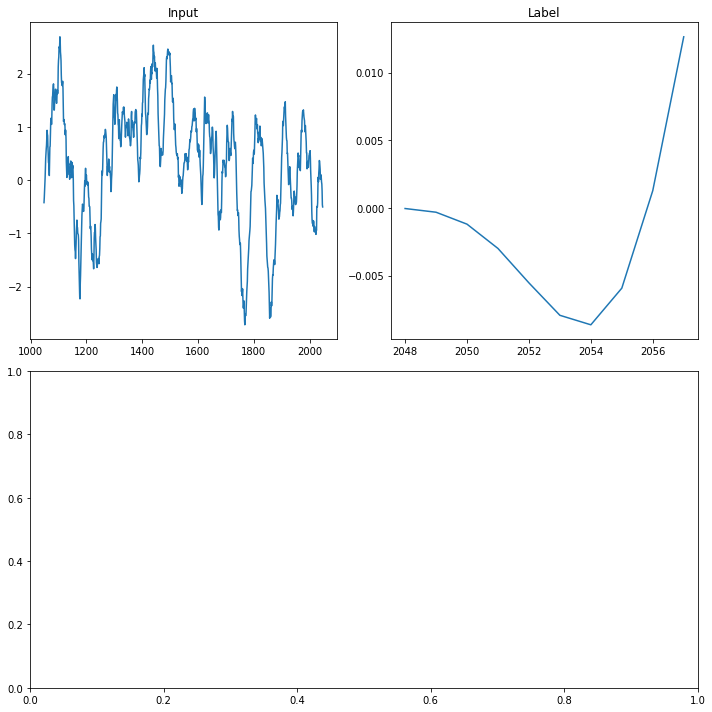

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

print(data.shape)

fig = plt.figure(figsize=(10,10))
gs = GridSpec(2,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

ax1.plot(np.arange(params.PREVIOUS_TIME-1000,params.PREVIOUS_TIME,1), data[0,0,params.PREVIOUS_TIME-1000:params.PREVIOUS_TIME])
ax1.set_title('Input')

ax2.plot(np.arange(params.PREVIOUS_TIME, params.PREVIOUS_TIME+params.LOOK_AHEAD, 1), labels[0,0,:])
ax2.set_title('Label')

# ax3.plot(np.arange(params.PREVIOUS_TIME-100, params.PREVIOUS_TIME+100, 1), full[0,0,params.PREVIOUS_TIME-100:])
# ax3.set_title('Full')

plt.tight_layout()
plt.show()

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader

batch_size = 32

split_idx = int(.75 * data.shape[0])

print(split_idx)
print(data.shape)
print(labels.shape)

train_data = DataLoader(TensorDataset(torch.Tensor(data[:split_idx, :, :]), torch.Tensor(labels[:split_idx, :, :])), batch_size=batch_size, shuffle=True)
valid_data = DataLoader(TensorDataset(torch.Tensor(data[split_idx:, :, :]), torch.Tensor(labels[split_idx:, :, :])), batch_size=batch_size, shuffle=False)

74996
(99995, 1, 2048)
(99995, 1, 10)


In [5]:
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.fft import rfft
from scipy import stats
from typing import Tuple, List, Optional

def get_norm_factor(full_lfp: np.ndarray) -> np.ndarray:
    norm_factor = []
    for i in range(full_lfp.shape[0]):
        lfp = np.squeeze(full_lfp[i,:,:].T)
        nfft = 2**7 # 128 samples
        f, Pxx = signal.welch(lfp, fs=1000, window='hamming', nperseg=nfft, scaling='spectrum')
        f = f.ravel()

        f_cutoff = max(np.argmax(Pxx),1)
        Pmax = Pxx[f_cutoff]
        idx = np.arange(f_cutoff,f.size)
        result = stats.linregress(np.log(f[idx]),np.log(Pxx[idx]))
        b = result.intercept
        a = -result.slope

        f_cutoff = np.exp((b-np.log(Pmax))/a)
        idx = f>f_cutoff
        Pfit = Pxx.copy()
        Pfit[idx] = np.exp(b)/f[idx]**a
        Pfit[~idx] = Pmax
        norm_factor.append(np.square(Pmax/Pfit))
    norm_factor = np.stack(norm_factor)
    return norm_factor

def fft_loss(output: torch.Tensor, target: torch.Tensor, norm_factor: Optional[torch.Tensor] = None) -> torch.Tensor:
    fft_data = (rfft(output, n=128).real - rfft(target, n=128).real)
    # print(norm_factor.shape)
    # print(fft_data.shape)
    sampled_loss = torch.sum(torch.square(torch.multiply(norm_factor, fft_data)), axis=1)
    # print(multiplied.shape)
    # loss = torch.sum(fft_data)
    loss = torch.sum(sampled_loss)
    # print(loss.shape)
    return loss

def train_model(model: nn.Module,
                training_loader: torch.utils.data.DataLoader,
                validation_loader: torch.utils.data.DataLoader,
                epochs: int,
                device: torch.device) -> Tuple[List[float], List[float]]:
    #splitting the dataloaders to generalize code
    data_loaders = {"train": training_loader, "val": validation_loader}
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=0)  #1e-5)
    # optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=0)
    loss_func = nn.MSELoss()
    decay_rate = .98 #0.98 #decay the lr each step to 98% of previous lr
    lr_sch = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    validation_loss, training_loss = [], []

    """
    You can easily adjust the number of epochs trained here by changing the number in the range
    """
    for epoch in tqdm(range(epochs), position=0, leave=True):
        train_loss = 0.0
        val_loss = 0.0
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            for i, (x, y) in enumerate(data_loaders[phase]):
                # print(y.shape)
                x = x.to(device)
                output = model(x)
                y = y.to(device)

                # norm_factor = torch.Tensor(get_norm_factor(x.to('cpu').detach().numpy())).to(device)
                # loss = fft_loss(torch.squeeze(output), torch.squeeze(y), norm_factor)

                # loss = loss_func(torch.squeeze(output), torch.squeeze(y[:,:,:params.LOOK_AHEAD]))

                loss = loss_func(torch.squeeze(output), torch.squeeze(y))
                #backprop
                optimizer.zero_grad()
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                    # if i == 104 and epoch % 10 == 0:
                    #     tqdm.write('First Layer Gradient: {}'.format(model.conv1.weight.grad))

                running_loss += loss.item()

            if phase == 'train':
                train_loss = running_loss
                lr_sch.step()
                training_loss.append(train_loss)
            else:
                val_loss = running_loss
                validation_loss.append(val_loss)

        # shows total loss
        if epoch%5 == 0:
        # if True:
            tqdm.write('[%d] train loss: %.6f val loss: %.6f' % (epoch + 1, train_loss, val_loss))
    return training_loss, validation_loss

In [6]:
import copy
from lfp_prediction.models.LFPNet import FCN, CNN, BaselineLSTM

epochs = 50

# model = CNN(in_size=2048, h_size=500, out_size=10)
# model = FCN(in_size=2048, h_size=500, out_size=10)
model = BaselineLSTM(in_size=1, h_size=50, out_size=10)
# model.load_state_dict(torch.load('LSTM_syn_gamma_decomposition.pth'))
model_initial = copy.deepcopy(model)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
t_loss, v_loss = train_model(model, train_data, valid_data, epochs, device)

  0%|          | 0/50 [00:00<?, ?it/s]

[1] train loss: 0.067825 val loss: 0.003642
[6] train loss: 0.011118 val loss: 0.003755
[11] train loss: 0.010844 val loss: 0.003636
[16] train loss: 0.010718 val loss: 0.003563
[21] train loss: 0.010656 val loss: 0.003489
[26] train loss: 0.010595 val loss: 0.003498
[31] train loss: 0.010545 val loss: 0.003504
[36] train loss: 0.010499 val loss: 0.003485
[41] train loss: 0.010481 val loss: 0.003466
[46] train loss: 0.010442 val loss: 0.003569


In [7]:
def validate_model(model: nn.Module,
                   validation_loader: torch.utils.data.DataLoader,
                   device: torch.device) -> Tuple[List[float], List[float]]:

    losses = {i:0 for i in range(look_back, 10, 1)}
    for i, (x, y) in enumerate(validation_loader):
        x = x.to(device)
        output = model(x)
        output = output.to("cpu").detach().numpy()
        y = y.to("cpu").detach().numpy()
        print(y.shape, output.shape)
        for t in range(1, params.LOOK_AHEAD + look_back, 1):
            y_true = y[:,:,t]
            y_pred = output[:,t]
            squared_error = (y_true - y_pred) ** 2 / len(y_true)
            # print(squared_error.shape)
            losses[t-look_back] += np.sum(squared_error)
    return losses


losses = validate_model(model, valid_data, device)
print(losses)

(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (32, 10)
(32, 1, 10) (

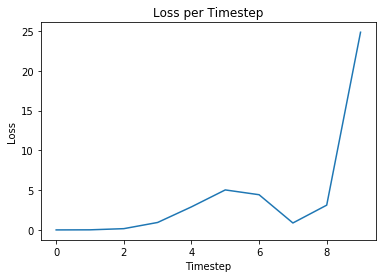

In [8]:
# with open('{}_{}NonCausal_LSTM.csv'.format(frequency_band[0], frequency_band[1]), 'w') as f:
#     for key in losses.keys():
#         f.write("%d,%f\n"%(key,losses[key]))

lists = sorted(losses.items())

timestep, loss_val = zip(*lists)
plt.plot(timestep, loss_val)
plt.xlabel('Timestep')
plt.ylabel('Loss')
plt.title('Loss per Timestep')
plt.show()

In [9]:
model.eval()
torch.save(model.state_dict(), 'LSTM_syn_gamma_withbg_decomposition.pth')

In [10]:
x, y = next(iter(valid_data))
model.eval()
x = x.to(device)
output = model(x)
x = x.to("cpu").detach().numpy()
output = output.to("cpu").detach().numpy()
y = y.to("cpu").detach().numpy()

print(x.shape)
print(y.shape)
print(output.shape)

(32, 1, 2048)
(32, 1, 10)
(32, 10)


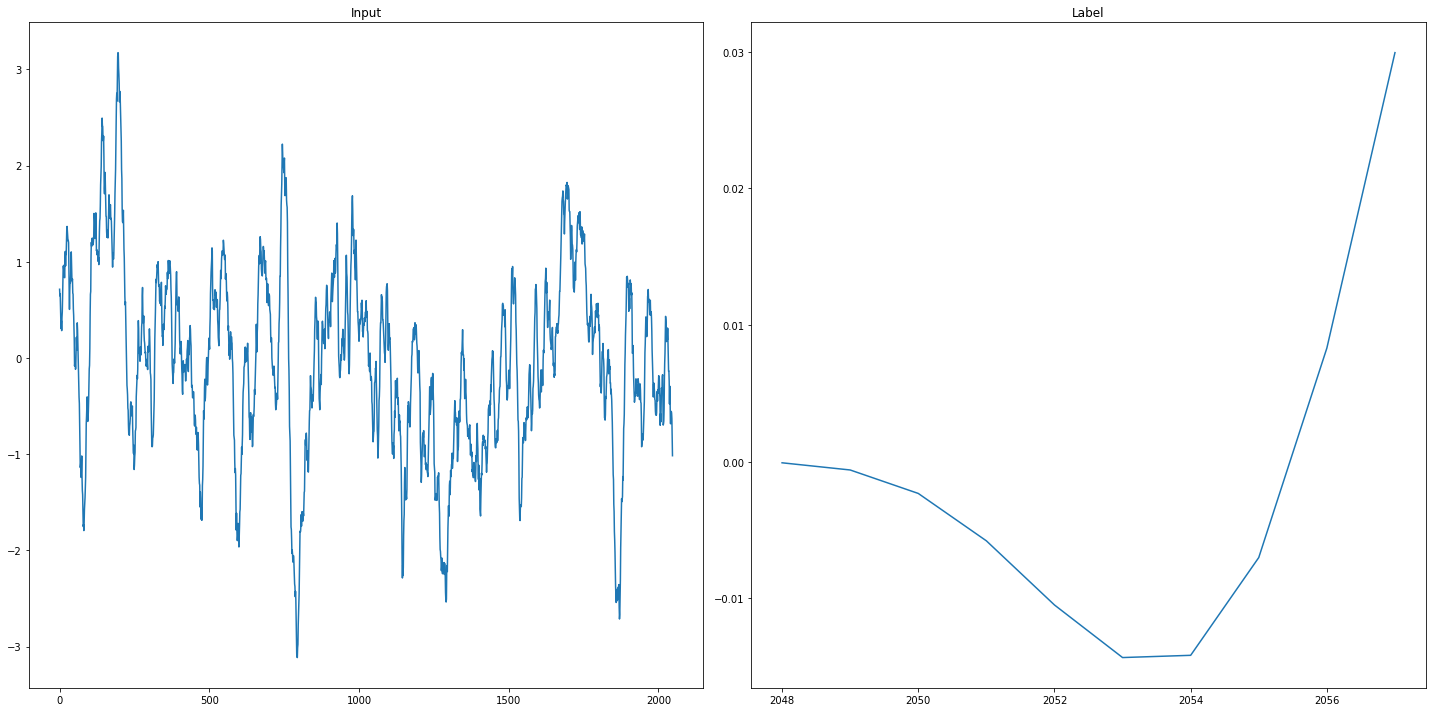

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

ax1.plot(np.arange(0,params.PREVIOUS_TIME,1), x[0,0,:params.PREVIOUS_TIME])
ax1.set_title('Input')

ax2.plot(np.arange(params.PREVIOUS_TIME-look_back, params.PREVIOUS_TIME+params.LOOK_AHEAD, 1), y[0,0,:])
ax2.set_title('Label')

plt.tight_layout()
plt.show()

(10,)
(10,)


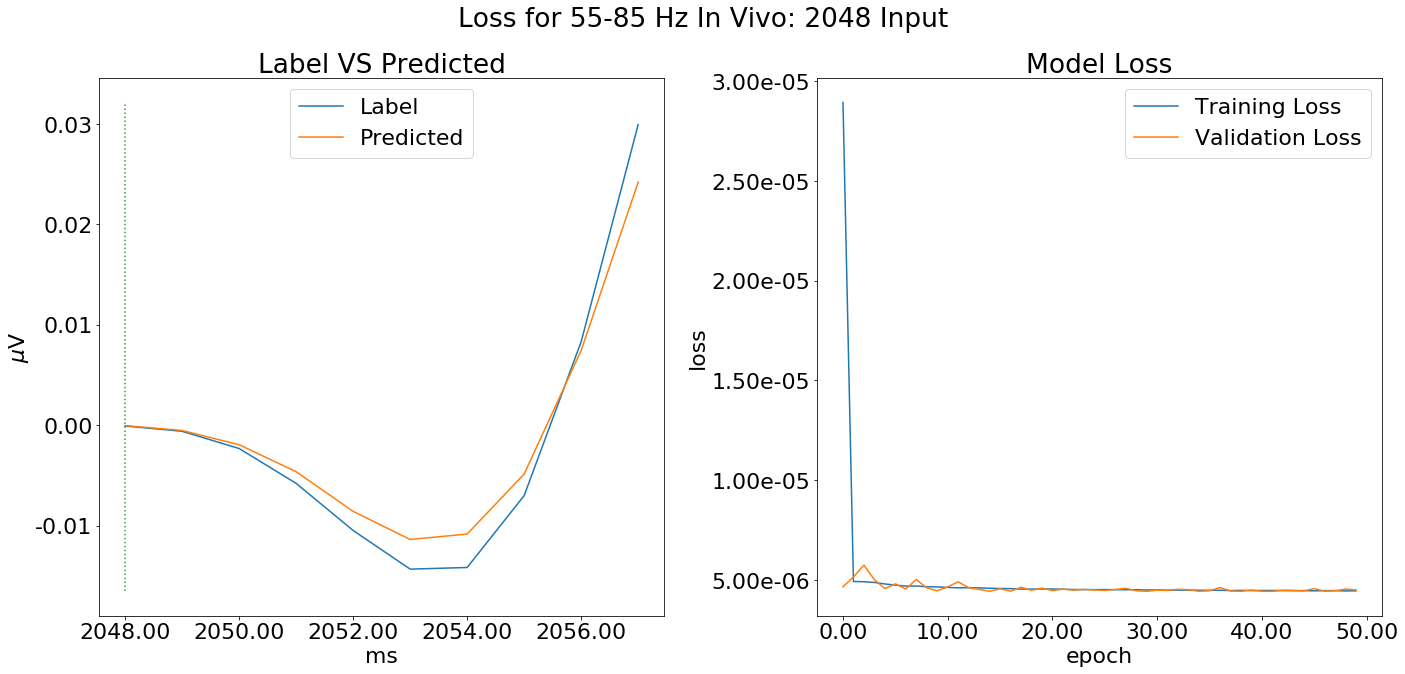

In [12]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

scaled_t_loss = [l/(split_idx/batch_size) for l in t_loss]
scaled_v_loss = [l/((data.shape[0] - split_idx)/batch_size) for l in v_loss]

plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 22

fig = plt.figure(figsize=(20,10))
gs = GridSpec(1,2)

# ax1 = fig.add_subplot()
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

fig.suptitle('Loss for {}-{} Hz In Vivo: 2048 Input'.format(frequency_band[0], frequency_band[1]))
# fig.suptitle('Loss for In Vivo Data: 2048 Input')

# t = np.arange(2028, 2128, 1)
# t = np.arange(params.PREVIOUS_TIME-20, params.PREVIOUS_TIME+80, 1)
t = np.arange(params.PREVIOUS_TIME-look_back, params.PREVIOUS_TIME+params.LOOK_AHEAD, 1)

time_var = 100

print(y[0,0,look_back:].shape)
print(output[0,look_back:].shape)

ax1.plot(t, y[0,0,:], label='Label')
ax1.plot(t, output[0,:], label='Predicted')
ax1.plot([params.PREVIOUS_TIME, params.PREVIOUS_TIME], ax1.get_ylim(), ':')
# axs[0].set_ylim(bottom=-0.0075, top=0.0075)
ax1.set_xlabel('ms')
ax1.set_ylabel(r'$\mu$V')
ax1.set_title('Label VS Predicted')
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax1.legend(loc='best')

ax2.plot(np.arange(epochs), np.array(scaled_t_loss), label='Training Loss')
ax2.plot(np.arange(epochs), np.array(scaled_v_loss), label='Validation Loss')
ax2.set_xlabel('epoch')
ax2.set_ylabel('loss')
ax2.set_title('Model Loss')
ax2.yaxis.set_major_formatter(FormatStrFormatter('%.2e'))
ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax2.legend(loc='best')


# z, a = signal.butter(4, frequency_band, btype='bandpass', output='ba', fs=1000)
# ax3.plot(np.arange(2028, 2128, 1), signal.lfilter(z, a, np.flip(y), axis=0)[0,0,:100], label='Label')
# ax3.plot(np.arange(2028, 2128, 1), signal.lfilter(z, a, np.flip(output[0,0,:]), axis=0), label='Predicted')
# ax3.plot([2048, 2048], ax3.get_ylim(), ':')
# ax3.set_xlabel('ms')
# ax3.set_ylabel(r'$\mu$V')
# ax3.set_title('Non-Causal Filtered Label VS Predicted')
# ax3.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# ax3.legend(loc='best')

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
# plt.savefig('{}_{}NonCausal_LSTM.png'.format(frequency_band[0], frequency_band[1]), format='png')
plt.show()